In [1]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "potato datset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    print(image_batch[0].numpy())

(32, 256, 256, 3)
[1 0 0 2 2 1 0 1 1 0 0 0 0 0 2 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 2]
[[[185. 176. 181.]
  [198. 189. 194.]
  [204. 195. 200.]
  ...
  [132. 127. 124.]
  [130. 126. 123.]
  [130. 126. 123.]]

 [[179. 170. 175.]
  [187. 178. 183.]
  [192. 183. 188.]
  ...
  [145. 140. 137.]
  [136. 132. 129.]
  [124. 120. 117.]]

 [[177. 168. 173.]
  [180. 171. 176.]
  [182. 173. 178.]
  ...
  [142. 137. 134.]
  [142. 138. 135.]
  [141. 137. 134.]]

 ...

 [[190. 180. 179.]
  [190. 180. 179.]
  [190. 180. 179.]
  ...
  [144. 126. 126.]
  [152. 134. 134.]
  [154. 136. 136.]]

 [[192. 182. 181.]
  [192. 182. 181.]
  [192. 182. 181.]
  ...
  [147. 129. 129.]
  [152. 134. 134.]
  [165. 147. 147.]]

 [[189. 179. 178.]
  [190. 180. 179.]
  [190. 180. 179.]
  ...
  [149. 131. 131.]
  [144. 126. 126.]
  [156. 138. 138.]]]


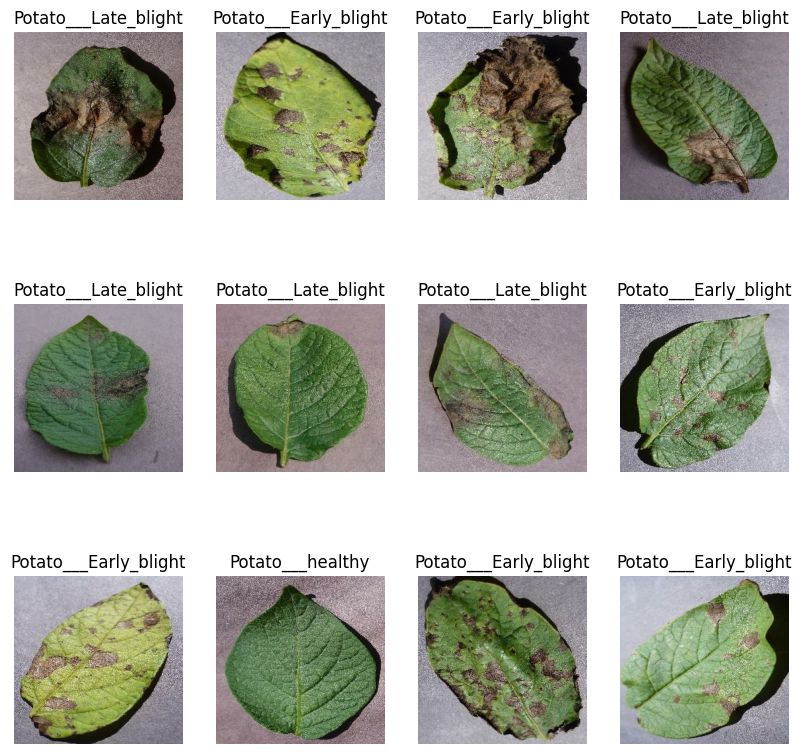

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
   for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [8]:
len(dataset)

68

In [9]:
# 80% for training
# 20% --> 10% for validation and 10% for testing


In [10]:
train_size=0.7
len(dataset)*train_size

47.599999999999994

In [11]:
train_ds=dataset.take(47)
len(train_ds)

47

In [12]:
test_ds=dataset.skip(47)
len(test_ds)

21

In [13]:
val_size=0.15
len(dataset)*val_size

10.2

In [14]:
val_ds=test_ds.take(10)
len(val_ds)

10

In [15]:
test_ds=test_ds.skip(10)
len(test_ds)

11

In [16]:
def get_dataset_partition_tf(ds, train_split=0.7, val_split=0.20, test_split=0.10, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [17]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [18]:
len(train_ds)


47

In [19]:
len(val_ds)

13

In [20]:
len(test_ds)

8

In [21]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [24]:
# Self-Attention Layer
class SelfAttention(layers.Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.W1 = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal", trainable=True)
        self.W2 = self.add_weight(shape=(self.units, 1), initializer="random_normal", trainable=True)

    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.W1))
        attention_weights = tf.nn.softmax(tf.matmul(score, self.W2), axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

# Define Model
n_class = 3
model = models.Sequential([
    layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),  # Explicitly define the input shape
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten the output before passing to Self-Attention
    layers.Flatten(),
    
    # Adding Self-Attention Layer
    SelfAttention(64),
    
    # Reshape the output to ensure compatibility with Dense layers
    layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),  # Adjust output dimensions for Dense layers
    
    layers.Dense(64, activation='relu'),
    layers.Dense(n_class, activation='softmax'),
])

# Model Summary
model.summary()

c:\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention (SelfAttention)  │ (None)                 │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,875 (718.26 KB)

 Trainable params: 183,875 (718.26 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

# Evaluate the model
scores = model.evaluate(test_ds)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.3902 - loss: 1.1014 - val_accuracy: 0.4784 - val_loss: 1.0271
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.4641 - loss: 0.9904 - val_accuracy: 0.4784 - val_loss: 0.8506
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.5084 - loss: 0.8701 - val_accuracy: 0.6587 - val_loss: 0.8421
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.6833 - loss: 0.7812 - val_accuracy: 0.7740 - val_loss: 0.7006
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8005 - loss: 0.6610 - val_accuracy: 0.8101 - val_loss: 0.6148
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.8268 - loss: 0.6027 - val_accuracy: 0.7308 - val_loss: 0.6864
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 175s 4s/step - accuracy: 0.8027 - loss: 0.5836 - val_accuracy: 0.7308 - val_loss: 0.6655
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.8353 - loss: 0.5280 - val_accuracy: 0.7428 - val_l

In [26]:
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 392ms/step - accuracy: 0.9487 - loss: 0.1234


In [27]:
scores

[0.0969780758023262, 0.9609375]

In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 47}

In [30]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [31]:
history.history['accuracy']

[0.447473406791687,
 0.46742022037506104,
 0.4933510720729828,
 0.717420220375061,
 0.8098404407501221,
 0.8071808218955994,
 0.8171542286872864,
 0.8510638475418091,
 0.845079779624939,
 0.8404255509376526,
 0.8829787373542786,
 0.8982712626457214,
 0.8942819237709045,
 0.8557180762290955,
 0.904920220375061,
 0.9069148898124695,
 0.9082446694374084,
 0.9055851101875305,
 0.9195478558540344,
 0.9115691781044006,
 0.8996010422706604,
 0.916223406791687,
 0.9188829660415649,
 0.9208776354789734,
 0.916223406791687,
 0.9135638475418091,
 0.9182180762290955,
 0.9155585169792175,
 0.9128989577293396,
 0.9188829660415649,
 0.9215425252914429,
 0.9255319237709045,
 0.9222074747085571,
 0.927526593208313,
 0.9222074747085571,
 0.9308510422706604,
 0.9208776354789734,
 0.9228723645210266,
 0.9335106611251831,
 0.9102393388748169,
 0.9368351101875305,
 0.9308510422706604,
 0.927526593208313,
 0.9355053305625916,
 0.928856372833252,
 0.9394946694374084,
 0.9527925252914429,
 0.936170220375061,
 

In [32]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

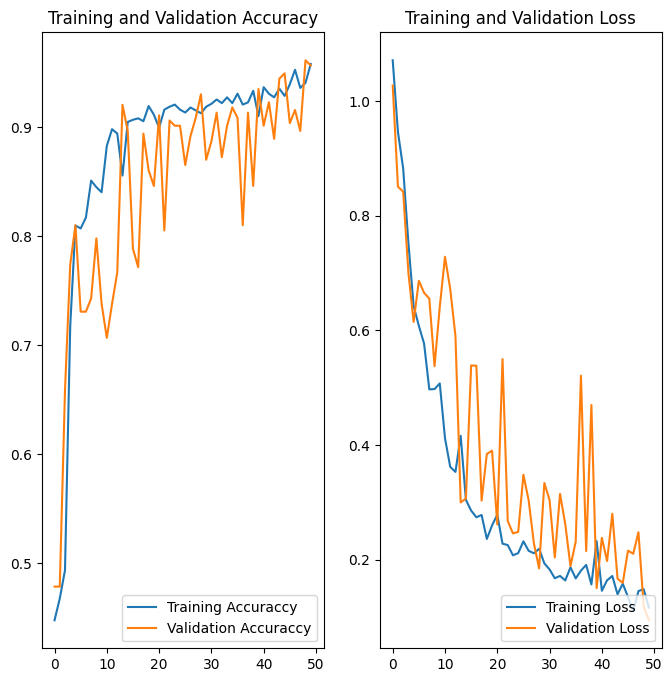

In [33]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label='Training Accuraccy')
plt.plot(range(EPOCHS),val_acc, label='Validation Accuraccy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label='Training Loss')
plt.plot(range(EPOCHS),val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

first image to predict
first image actual label :  Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[0.9862067  0.00263542 0.01115785]
0
predicted label: Potato___Early_blight


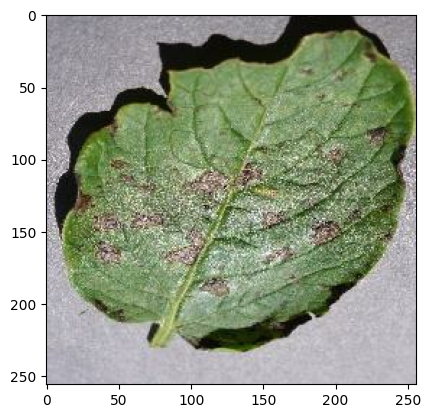

In [34]:
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("first image actual label : ",class_names[first_label])

    batch_prediction=model.predict(images_batch)
    print(batch_prediction[0])
    # predi_class_idx=np.argmax(batch_prediction[0])
    print(np.argmax(batch_prediction[0]))
    # print("predicted class : ",class_names[predi_class_idx])
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

First image to predict:


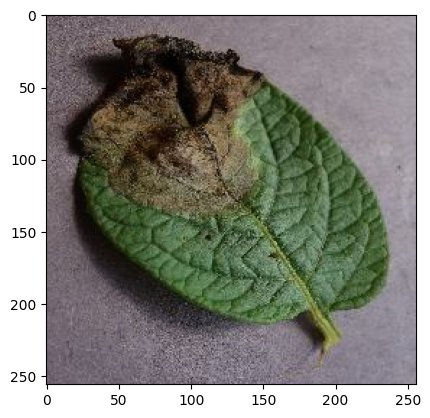

First image actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
Prediction probabilities: [2.1092981e-16 9.9877113e-01 1.2289013e-03]
Predicted class index: 1
Predicted label: Potato___Late_blight


In [35]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First image to predict:")
    plt.imshow(first_image)
    plt.show()
    print("First image actual label:", class_names[first_label])

    # Predict using the correct variable name
    batch_prediction = model.predict(images_batch)
    
    print("Prediction probabilities:", batch_prediction[0])
    predicted_class_idx = np.argmax(batch_prediction[0])
    print("Predicted class index:", predicted_class_idx)
    print("Predicted label:", class_names[predicted_class_idx])

In [36]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)

    predictions=model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


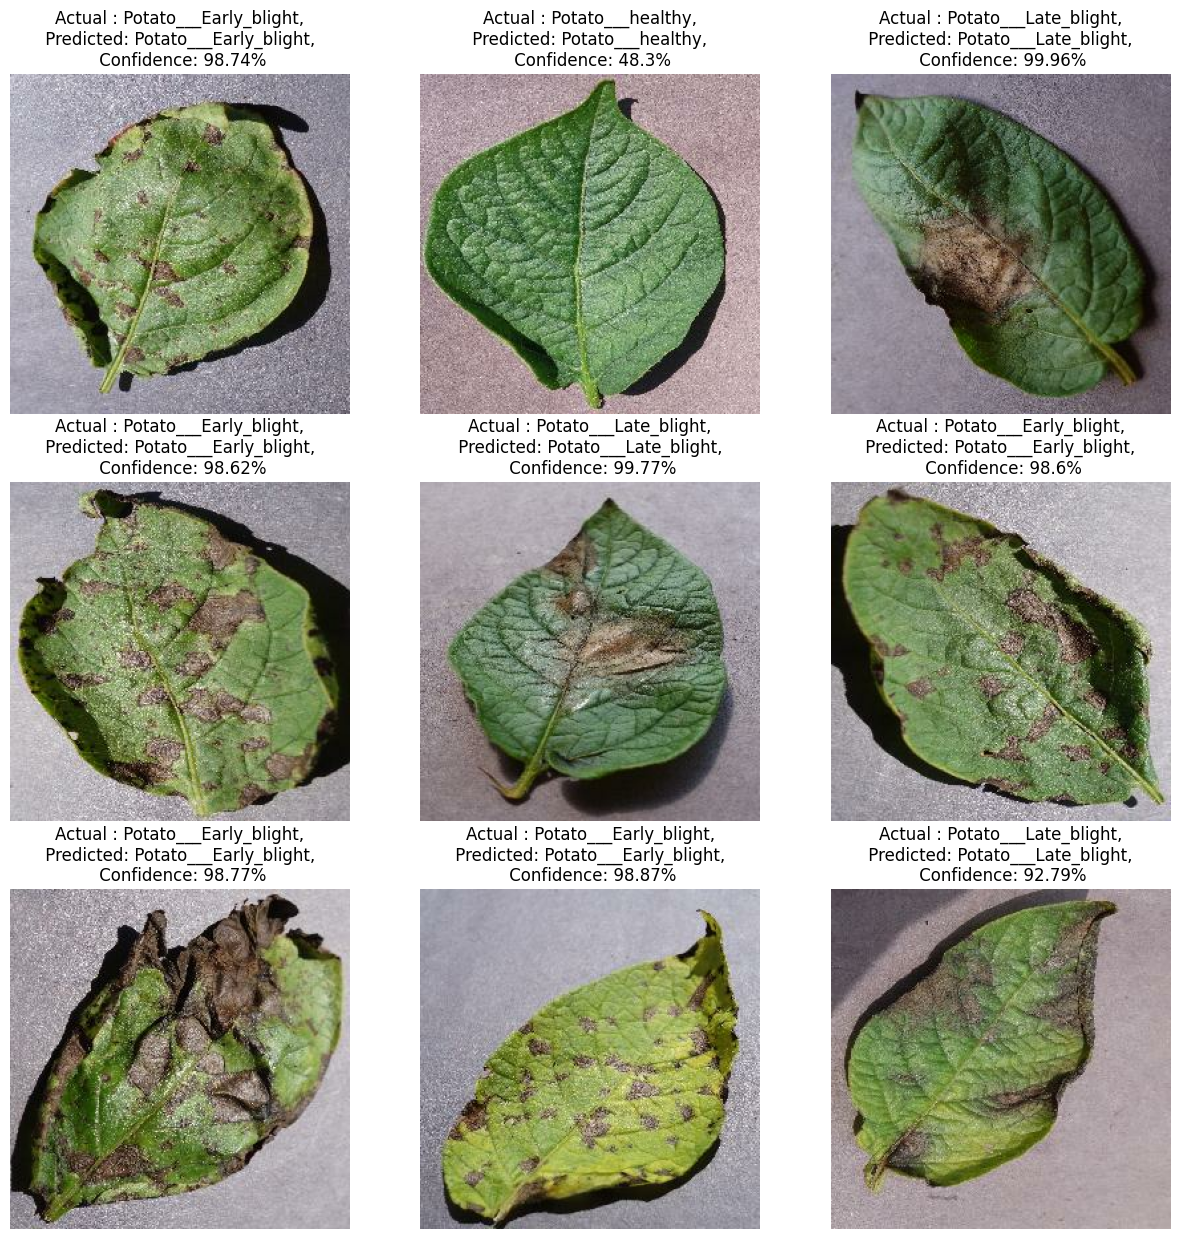

In [37]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence =predict(model, images[i].numpy())
        actual_class=class_names[labels[i]]

        plt.title(f"Actual : {actual_class},\n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis('off')

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to predict and return the predicted class, confidence
def predict(model, image):
    image = np.expand_dims(image, axis=0)  # Adding batch dimension
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction) * 100  # Confidence in percentage
    return predicted_class, confidence

# Function to calculate PSNR
def calculate_psnr(imageA, imageB):
    mse = np.mean((imageA - imageB) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Initialize arrays for actual and predicted labels
y_true = []
y_pred = []

# Your provided code: Loop through test dataset and plot images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        # Predict and get the class and confidence
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = labels[i].numpy()

        # Append true and predicted classes for later metrics calculation
        y_true.append(actual_class)
        y_pred.append(predicted_class)

        # Plot title with actual and predicted class along with confidence
        plt.title(f"Actual: {class_names[actual_class]},\nPredicted: {class_names[predicted_class]},\nConfidence: {confidence:.2f}%")
        plt.axis('off')

# Convert to numpy arrays for metrics calculation
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Handle dynamic class names based on y_true
unique_labels = np.unique(y_true)  # Get unique labels in y_true
target_class_names = [class_names[i] for i in unique_labels]  # Match only the relevant class names

# 2. Classification Report (Precision, Recall, F1 Score per class)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_class_names, labels=unique_labels))

# 3. Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 4. Precision, Recall, F1 Score (Weighted Average)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 5. Mean Squared Error (Optional for regression tasks)
mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

# 6. PSNR (Peak Signal-to-Noise Ratio) for image comparison
# Assuming you're comparing actual vs predicted image labels
psnr_values = [calculate_psnr(images[i].numpy(), images[i].numpy()) for i in range(9)]  # Placeholder comparison
print(f"PSNR: {np.mean(psnr_values):.2f} dB")

# 7. AUC (only for binary classification tasks)
if len(unique_labels) == 2:  # AUC is for binary classification
    auc = roc_auc_score(y_true, y_pred)
    print(f"AUC: {auc:.4f}")
else:
    print("AUC not applicable for multi-class classification.")


In [39]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [40]:
model.save(r"D:\Study\plant disease project\models\model_v14.keras")
